<img src="https://assets.bwbx.io/images/users/iqjWHBFdfxIU/iE_HajpA5qVQ/v1/1000x-1.jpg" alt="Picture1" border="0">


## <b> Uber Data Analysis to predict the price

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression,LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import gc
import os
import sys
%matplotlib inline

In [ ]:
##!wget https://www.dropbox.com/s/ncqb2ctkg7da11k/weather.csv

In [ ]:
##!wget https://www.dropbox.com/s/brixkogrmhan6ed/cab_rides.csv

In [2]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
cab_data = pd.read_csv("cab_rides.csv")
cab_data=reduce_mem_usage(cab_data)
weather_data = pd.read_csv("weather.csv")
weather_data=reduce_mem_usage(weather_data)


Memory usage of dataframe is 52.88 MB --> 44.95 MB (Decreased by 15.0%)
Memory usage of dataframe is 0.38 MB --> 0.22 MB (Decreased by 43.7%)


In [5]:
cab_data

distance cab_type     time_stamp    destination            source  \
0           0.44     Lyft  1544952607890  North Station  Haymarket Square   
1           0.44     Lyft  1543284023677  North Station  Haymarket Square   
2           0.44     Lyft  1543366822198  North Station  Haymarket Square   
3           0.44     Lyft  1543553582749  North Station  Haymarket Square   
4           0.44     Lyft  1543463360223  North Station  Haymarket Square   
...          ...      ...            ...            ...               ...   
693066      1.00     Uber  1543708385534      North End          West End   
693067      1.00     Uber  1543708385534      North End          West End   
693068      1.00     Uber  1543708385534      North End          West End   
693069      1.00     Uber  1543708385534      North End          West End   
693070      1.00     Uber  1543708385534      North End          West End   

        price  surge_multiplier                                    id  \
0         5.0               1.0  424553bb-7174-41ea-aeb4-fe06d4f4b9d7   
1        11.0               1.0  4bd23055-6827-41c6-b23b-3c491f24e74d   
2         7.0               1.0  981a3613-77af-4620-a42a-0c0866077d1e   
3        26.0               1.0  c2d88af2-d278-4bfd-a8d0-29ca77cc5512   
4         9.0               1.0  e0126e1f-8ca9-4f2e-82b3-50505a09db9a   
...       ...               ...                                   ...   
693066   13.0               1.0  616d3611-1820-450a-9845-a9ff304a4842   
693067    9.5               1.0  633a3fc3-1f86-4b9e-9d48-2b7132112341   
693068    NaN               1.0  64d451d0-639f-47a4-9b7c-6fd92fbd264f   
693069   27.0               1.0  727e5f07-a96b-4ad1-a2c7-9abc3ad55b4e   
693070   10.0               1.0  e7fdc087-fe86-40a5-a3c3-3b2a8badcbda   

                                  product_id          name  
0                                  lyft_line        Shared  
1                               lyft_premier           Lux  
2                                       lyft          Lyft  
3                                lyft_luxsuv  Lux Black XL  
4                                  lyft_plus       Lyft XL  
...                                      ...           ...  
693066  6f72dfc5-27f1-42e8-84db-ccc7a75f6969        UberXL  
693067  55c66225-fbe7-4fd5-9072-eab1ece5e23e         UberX  
693068  8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a          Taxi  
693069  6d318bcc-22a3-4af6-bddd-b409bfce1546     Black SUV  
693070  997acbb5-e102-41e1-b155-9df7de0a73f2      UberPool  

[693071 rows x 10 columns]

In [6]:
import datetime
cab_data['datetime']= pd.to_datetime(cab_data['time_stamp'])
cab_data
weather_data['date_time'] = pd.to_datetime(weather_data['time_stamp'])

In [7]:
cab_data.columns

Index(['distance', 'cab_type', 'time_stamp', 'destination', 'source', 'price',
       'surge_multiplier', 'id', 'product_id', 'name', 'datetime'],
      dtype='object')

In [8]:
weather_data.columns

Index(['temp', 'location', 'clouds', 'pressure', 'rain', 'time_stamp',
       'humidity', 'wind', 'date_time'],
      dtype='object')

In [9]:
cab_data.shape

(693071, 11)

In [10]:
weather_data.shape

(6276, 9)

In [11]:
cab_data.describe()

distance    time_stamp          price  surge_multiplier
count  693071.000000  6.930710e+05  637976.000000     693071.000000
mean        2.189430  1.544046e+12      16.545126          1.013870
std         1.138937  6.891925e+08       9.324359          0.091641
min         0.020000  1.543204e+12       2.500000          1.000000
25%         1.280000  1.543444e+12       9.000000          1.000000
50%         2.160000  1.543737e+12      13.500000          1.000000
75%         2.920000  1.544828e+12      22.500000          1.000000
max         7.860000  1.545161e+12      97.500000          3.000000

In [12]:
weather_data.describe()

temp       clouds     pressure        rain    time_stamp  \
count  6276.000000  6276.000000  6276.000000  894.000000  6.276000e+03   
mean     39.090473     0.677777  1008.445190    0.057652  1.543857e+09   
std       6.022055     0.314284    12.870773    0.100758  6.659340e+05   
min      19.620001     0.000000   988.250000    0.000200  1.543204e+09   
25%      36.077501     0.440000   997.747498    0.004900  1.543387e+09   
50%      40.130001     0.780000  1007.659973    0.014850  1.543514e+09   
75%      42.832501     0.970000  1018.479980    0.060925  1.544691e+09   
max      55.410000     1.000000  1035.119995    0.780700  1.545159e+09   

          humidity         wind  
count  6276.000000  6276.000000  
mean      0.763985     6.802812  
std       0.127340     3.633466  
min       0.450000     0.290000  
25%       0.670000     3.517500  
50%       0.760000     6.570000  
75%       0.890000     9.920000  
max       0.990000    18.180000

In [13]:
a=pd.concat([cab_data,weather_data])

In [14]:
a['day']=a.date_time.dt.day
a['hour']=a.date_time.dt.hour

In [15]:
a.fillna(0,inplace=True)

In [16]:
a.columns

Index(['distance', 'cab_type', 'time_stamp', 'destination', 'source', 'price',
       'surge_multiplier', 'id', 'product_id', 'name', 'datetime', 'temp',
       'location', 'clouds', 'pressure', 'rain', 'humidity', 'wind',
       'date_time', 'day', 'hour'],
      dtype='object')

In [17]:
a.groupby('cab_type').count()

distance  time_stamp  destination  source   price  surge_multiplier  \
cab_type                                                                        
0             6276        6276         6276    6276    6276              6276   
Lyft        307408      307408       307408  307408  307408            307408   
Uber        385663      385663       385663  385663  385663            385663   

              id  product_id    name  datetime    temp  location  clouds  \
cab_type                                                                   
0           6276        6276    6276      6276    6276      6276    6276   
Lyft      307408      307408  307408    307408  307408    307408  307408   
Uber      385663      385663  385663    385663  385663    385663  385663   

          pressure    rain  humidity    wind  date_time     day    hour  
cab_type                                                                 
0             6276    6276      6276    6276       6276    6276    6276  
Lyft        307408  307408    307408  307408     307408  307408  307408  
Uber        385663  385663    385663  385663     385663  385663  385663

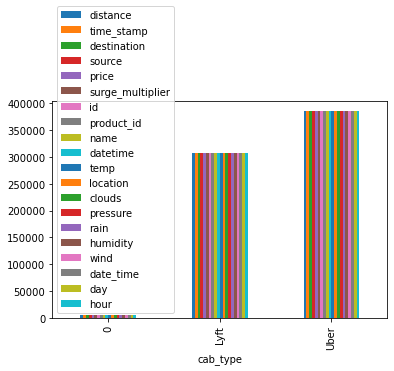

In [18]:
a.groupby('cab_type').count().plot.bar()


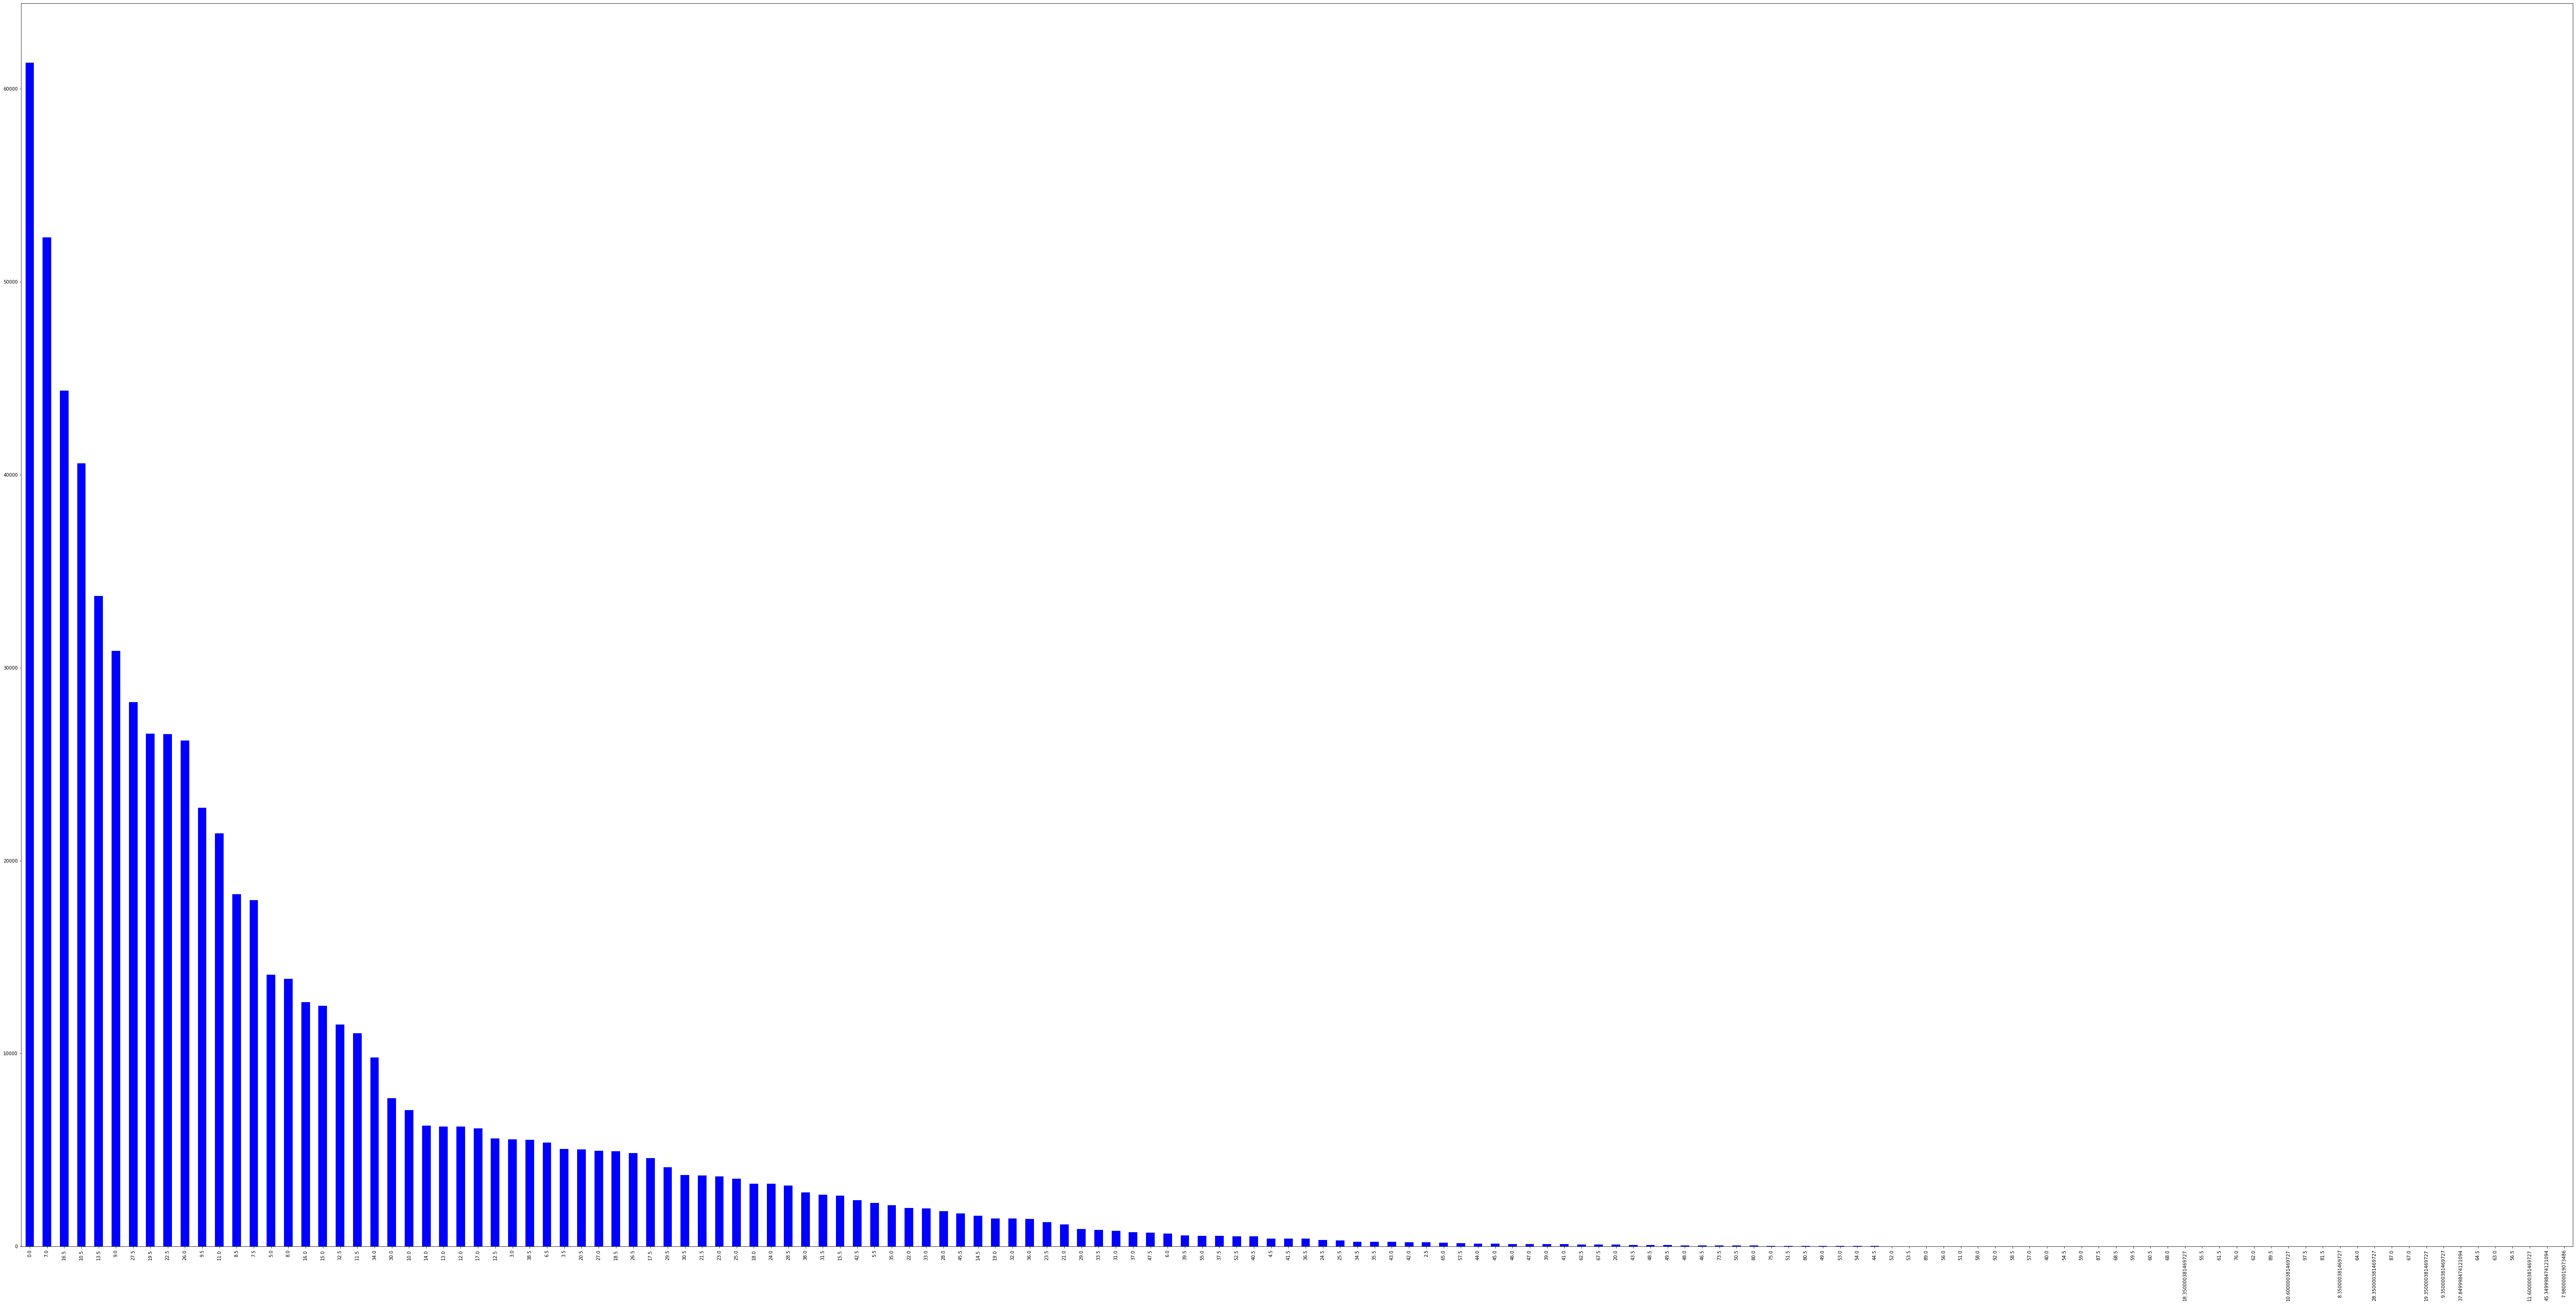

In [19]:
a['price'].value_counts().plot(kind='bar',figsize=(100,50),color='blue')


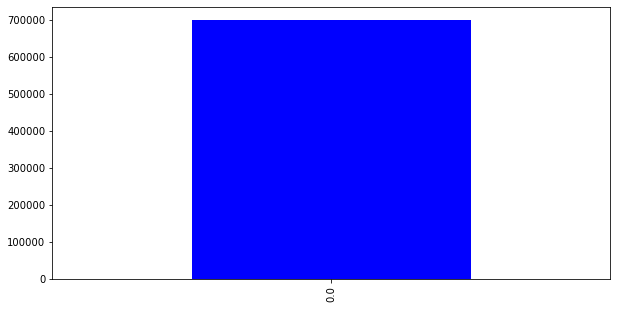

In [20]:
a['hour'].value_counts().plot(kind='bar',figsize=(10,5),color='blue')


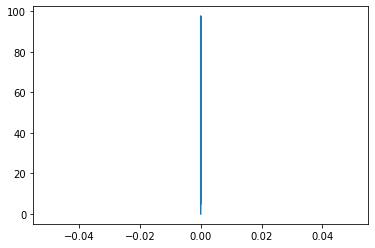

In [21]:
import matplotlib.pyplot as plt
x=a['hour']
y=a['price']
plt.plot(x,y)
plt.show()


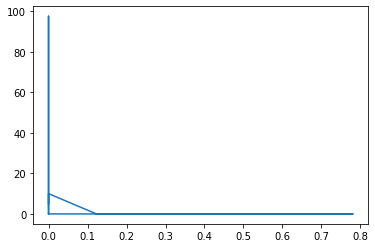

In [22]:
x=a['rain']
y=a['price']
plt.plot(x,y)
plt.show()

In [23]:
a.columns

Index(['distance', 'cab_type', 'time_stamp', 'destination', 'source', 'price',
       'surge_multiplier', 'id', 'product_id', 'name', 'datetime', 'temp',
       'location', 'clouds', 'pressure', 'rain', 'humidity', 'wind',
       'date_time', 'day', 'hour'],
      dtype='object')

In [24]:
x1=a[['distance', 'temp','clouds', 'pressure', 'humidity','wind','rain','day','hour','surge_multiplier','clouds']]
y1=a['price']

In [25]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
x_train, y_train, x_test, y_test = train_test_split(x1, y1, test_size = 0.25, random_state = 42)

In [26]:
linear=LinearRegression()
linear.fit(x_train,x_test)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [27]:
predictions=linear.predict(y_train)

In [28]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
df

Actual  Predicted
81607     42.5  32.547916
354        0.0  14.755608
471801    32.5  16.816969
407645    27.5  10.480192
474760    27.5  10.556539
...        ...        ...
538489     7.5  10.709232
579511    13.5  15.519075
5421       9.0  11.828984
279982     8.0  11.854433
236315    27.5  13.228673

[174837 rows x 2 columns]

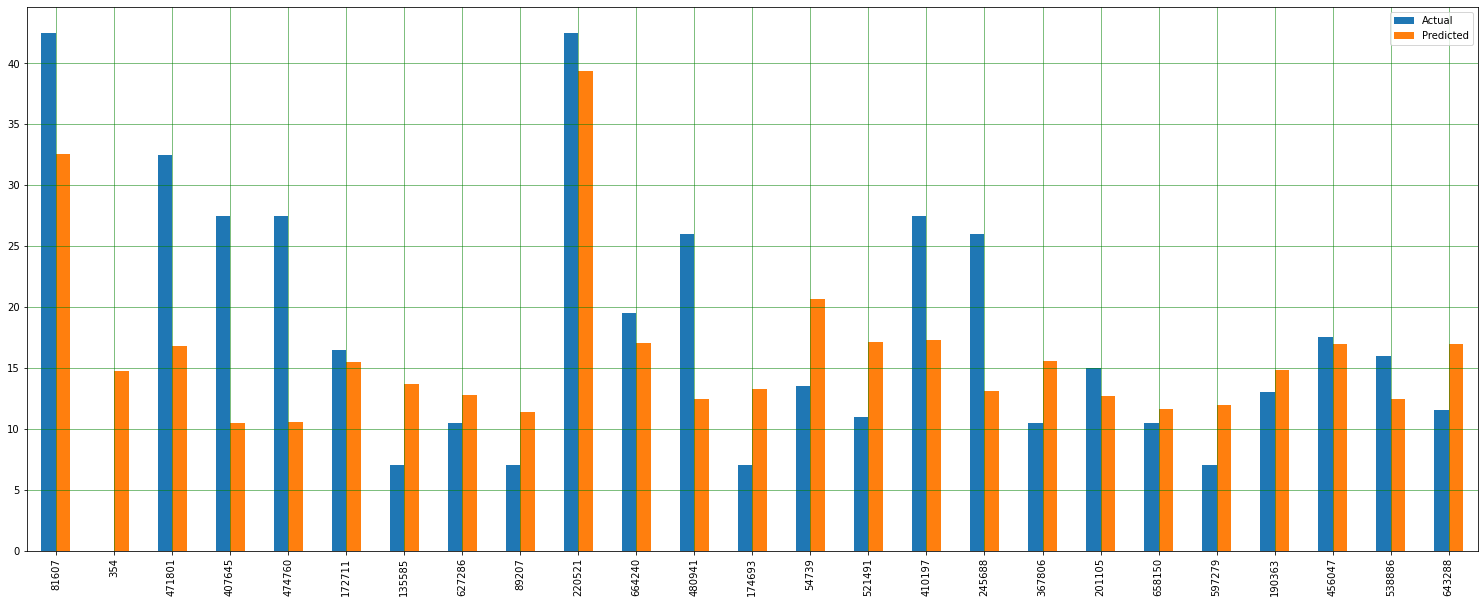

In [29]:
df1 = df.head(25)
df1.plot(kind='bar',figsize=(26,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

<img src="https://eng.uber.com/wp-content/uploads/2019/04/Header-.png" alt="Picture1" border="0">